In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=5a2116495333cba56bbae1f8bdbbaa9d92b4e1ad5ca033bfc68e94cc180f9535
  Stored in directory: /root/.cache/pip/wheels/aa/8a/36/59ed4f6fbcb6100967618eeb0696046bf9777a41ac2ff1f9b9
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8368 sha256=1d6a8bc282aa042f0c352d16c13f39615b125787a7d9daed99ad09f4da28e4a5
  Stored in directory: /root/.cache/pip/wheels/ae/25/47/4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking


In [9]:
import numpy as np
import pandas as pd
import yfinance as fyf
import statsmodels.tsa. stattools
import statsmodels.tsa.api as smt

from pandas import read_csv
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf

keras = tf.keras

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

stocks='QCOM'
stocks=stocks.split()
data = fyf.download(stocks, start = '2016-02-01', end = '2021-01-25')['Close']
data.tail()

[*********************100%***********************]  1 of 1 completed


Date
2021-01-15    157.089996
2021-01-19    163.770004
2021-01-20    164.600006
2021-01-21    164.750000
2021-01-22    162.419998
Name: Close, dtype: float64

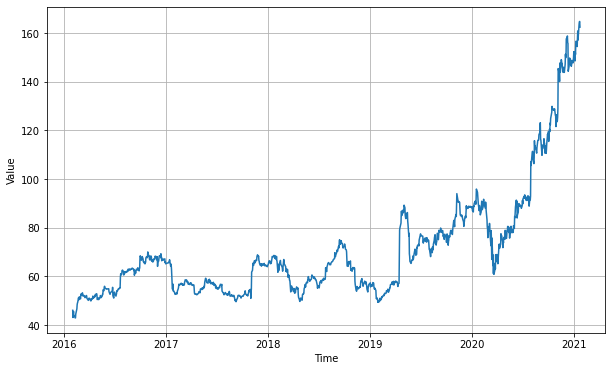

In [14]:
plt.figure(figsize=(10, 6))
plot_series(data.index, data.values)
plt.show()

### Moving Average forescast

First, we split the data into training and validation sets.

In [15]:
split_time = 1000
time_train = data.index[:split_time]
x_train = data.values[:split_time]
time_valid = data.index[split_time:]
x_valid = data.values[split_time:]

Now we start from a simple MA model which is a naive forecast based on past values, this will be our baseline model. Let window size be 30 days, so we predict future value based on the average of the past 30 days. 

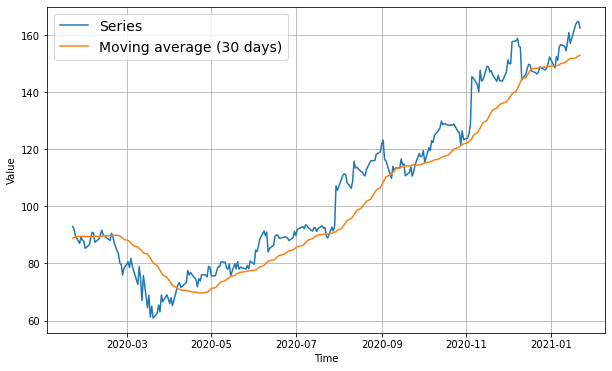

In [54]:
def moving_average_forecast(series, window_size):
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size -1:-1] / window_size

moving_avg = moving_average_forecast(data.values, 30)[split_time-30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

Our time series has a steep trend, so let's try to remove it and see how the forecast will change.

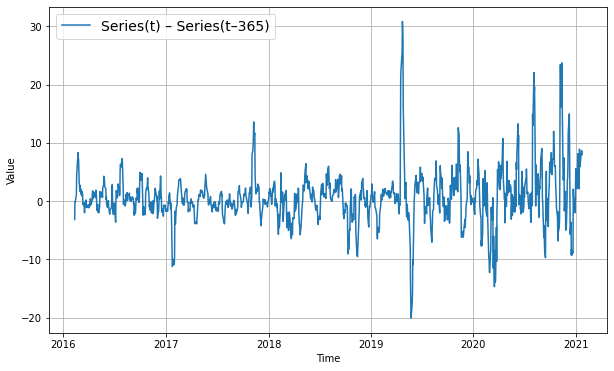

In [65]:
diff_series = (data.values[7:] - data.values[:-7])
diff_time = data.index[7:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

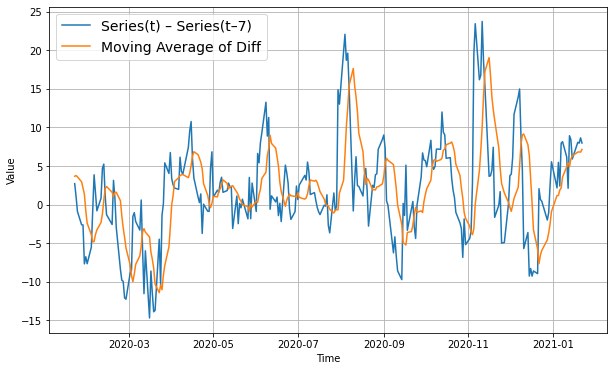

In [68]:
diff_moving_avg = moving_average_forecast(diff_series, 7)[split_time - 7 - 7:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 7:], label="Series(t) – Series(t–7)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

Let's bring back the trend by adding past values from t-7.

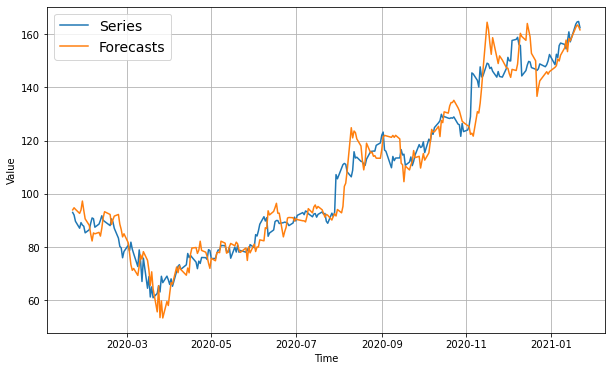

In [70]:
diff_moving_avg_plus_past = data.values[split_time - 7:-7] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [71]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

4.821142263165743

The above forecast looks good, although there's some noise coming from the past values of the series. Now let's use a moving averaging on past values to reduce the noise. 

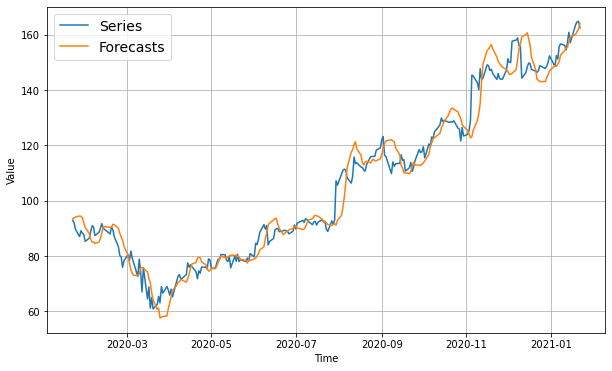

In [76]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(data.values[split_time - 10:-4], 6) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [77]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

4.087172182481478

Looks better! So our baseline model has MAE of 4.08.

### RNN

We proceed with RNN. Here we do not pre-process the data by removing the trend, we use original time series.

In [20]:
keras.backend.clear_session()
tf.random.set_seed(6)
np.random.seed(6)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal',
                     activation='relu', input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
lambda epoch: 1e-8 * 10 ** (epoch /20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer, 
             metrics=['mae'])
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 35ms/step - loss: 16.8970 - mae: 17.3923
Epoch 2/100
8/8 [==============================] - 0s 29ms/step - loss: 16.6788 - mae: 17.1734
Epoch 3/100
8/8 [==============================] - 0s 28ms/step - loss: 16.2378 - mae: 16.7333
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 15.7081 - mae: 16.2029
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 15.2817 - mae: 15.7767
Epoch 6/100
8/8 [==============================] - 0s 28ms/step - loss: 14.6988 - mae: 15.1938
Epoch 7/100
8/8 [==============================] - 0s 27ms/step - loss: 13.9890 - mae: 14.4837
Epoch 8/100
8/8 [==============================] - 0s 29ms/step - loss: 13.5969 - mae: 14.0922
Epoch 9/100
8/8 [==============================] - 0s 29ms/step - loss: 12.9209 - mae: 13.4138
Epoch 10/100
8/8 [==============================] - 0s 27ms/step - loss: 12.4176 - mae: 12.9080
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 0s 28ms/step - loss: 21.0178 - mae: 21.5150
Epoch 88/100
8/8 [==============================] - 0s 27ms/step - loss: 13.1048 - mae: 13.6008
Epoch 89/100
8/8 [==============================] - 0s 27ms/step - loss: 12.7441 - mae: 13.2373
Epoch 90/100
8/8 [==============================] - 0s 27ms/step - loss: 9.7329 - mae: 10.2244
Epoch 91/100
8/8 [==============================] - 0s 29ms/step - loss: 8.8738 - mae: 9.3662
Epoch 92/100
8/8 [==============================] - 0s 34ms/step - loss: 12.9402 - mae: 13.4309
Epoch 93/100
8/8 [==============================] - 0s 30ms/step - loss: 15.0601 - mae: 15.5560
Epoch 94/100
8/8 [==============================] - 0s 30ms/step - loss: 15.9894 - mae: 16.4857
Epoch 95/100
8/8 [==============================] - 0s 27ms/step - loss: 10.6221 - mae: 11.1098
Epoch 96/100
8/8 [==============================] - 0s 27ms/step - loss: 10.8140 - mae: 11.3066
Epoch 97/100
8/8 [==============================] - 0s 2

(1e-08, 0.0001, 0.0, 30.0)

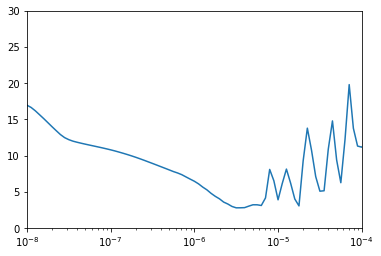

In [21]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

The optimal learning rate is about 1e-6, so let's try that. We will save the best model to use it further for forecasting. 

In [26]:
keras.backend.clear_session()
tf.random.set_seed(6)
np.random.seed()

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                  batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)


model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5', save_best_only = True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
         validation_data = valid_set,
         callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 143ms/step - loss: 110.3635 - mae: 110.8635 - val_loss: 126.3805 - val_mae: 126.8805
Epoch 2/500
8/8 [==============================] - 0s 42ms/step - loss: 72.5601 - mae: 73.0601 - val_loss: 45.7177 - val_mae: 46.2176
Epoch 3/500
8/8 [==============================] - 0s 42ms/step - loss: 13.6905 - mae: 14.1854 - val_loss: 32.7600 - val_mae: 33.2503
Epoch 4/500
8/8 [==============================] - 0s 43ms/step - loss: 11.8420 - mae: 12.3335 - val_loss: 41.3061 - val_mae: 41.8047
Epoch 5/500
8/8 [==============================] - 0s 41ms/step - loss: 9.6844 - mae: 10.1675 - val_loss: 39.2082 - val_mae: 39.7073
Epoch 6/500
8/8 [==============================] - 0s 42ms/step - loss: 7.9144 - mae: 8.4021 - val_loss: 35.5362 - val_mae: 36.0334
Epoch 7/500
8/8 [==============================] - 0s 41ms/step - loss: 7.9170 - mae: 8.4040 - val_loss: 38.4007 - val_mae: 38.8986
Epoch 8/500
8/8 [==============================] - 0s 41ms/ste

8/8 [==============================] - 0s 42ms/step - loss: 2.2602 - mae: 2.6696 - val_loss: 16.0501 - val_mae: 16.5345
Epoch 63/500
8/8 [==============================] - 0s 39ms/step - loss: 2.2952 - mae: 2.7042 - val_loss: 16.0418 - val_mae: 16.5267
Epoch 64/500
8/8 [==============================] - 0s 42ms/step - loss: 2.1906 - mae: 2.5981 - val_loss: 15.8776 - val_mae: 16.3618
Epoch 65/500
8/8 [==============================] - 0s 43ms/step - loss: 2.1802 - mae: 2.5862 - val_loss: 15.7997 - val_mae: 16.2839
Epoch 66/500
8/8 [==============================] - 0s 43ms/step - loss: 2.1806 - mae: 2.5868 - val_loss: 15.7811 - val_mae: 16.2657
Epoch 67/500
8/8 [==============================] - 0s 42ms/step - loss: 2.1670 - mae: 2.5748 - val_loss: 15.5346 - val_mae: 16.0182
Epoch 68/500
8/8 [==============================] - 0s 42ms/step - loss: 2.1228 - mae: 2.5307 - val_loss: 15.3303 - val_mae: 15.8128
Epoch 69/500
8/8 [==============================] - 0s 42ms/step - loss: 2.1699 - 

8/8 [==============================] - 0s 40ms/step - loss: 1.5665 - mae: 1.9721 - val_loss: 13.2901 - val_mae: 13.7727
Epoch 124/500
8/8 [==============================] - 0s 41ms/step - loss: 1.5696 - mae: 1.9760 - val_loss: 13.2985 - val_mae: 13.7812
Epoch 125/500
8/8 [==============================] - 0s 40ms/step - loss: 1.5451 - mae: 1.9509 - val_loss: 13.2269 - val_mae: 13.7086
Epoch 126/500
8/8 [==============================] - 0s 41ms/step - loss: 1.5097 - mae: 1.9118 - val_loss: 13.1968 - val_mae: 13.6787
Epoch 127/500
8/8 [==============================] - 0s 40ms/step - loss: 1.5087 - mae: 1.9127 - val_loss: 13.1130 - val_mae: 13.5936
Epoch 128/500
8/8 [==============================] - 0s 40ms/step - loss: 1.5031 - mae: 1.9066 - val_loss: 13.0766 - val_mae: 13.5569
Epoch 129/500
8/8 [==============================] - 0s 42ms/step - loss: 1.5019 - mae: 1.9043 - val_loss: 13.0242 - val_mae: 13.5043
Epoch 130/500
8/8 [==============================] - 0s 41ms/step - loss: 1.

8/8 [==============================] - 0s 40ms/step - loss: 1.2227 - mae: 1.6202 - val_loss: 12.6790 - val_mae: 13.1625
Epoch 185/500
8/8 [==============================] - 0s 40ms/step - loss: 1.2178 - mae: 1.6176 - val_loss: 12.6555 - val_mae: 13.1388
Epoch 186/500
8/8 [==============================] - 0s 41ms/step - loss: 1.2528 - mae: 1.6530 - val_loss: 12.5574 - val_mae: 13.0394
Epoch 187/500
8/8 [==============================] - 0s 40ms/step - loss: 1.2204 - mae: 1.6184 - val_loss: 12.4145 - val_mae: 12.8945
Epoch 188/500
8/8 [==============================] - 0s 42ms/step - loss: 1.2244 - mae: 1.6215 - val_loss: 12.5176 - val_mae: 12.9993
Epoch 189/500
8/8 [==============================] - 0s 41ms/step - loss: 1.2151 - mae: 1.6115 - val_loss: 12.5469 - val_mae: 13.0292
Epoch 190/500
8/8 [==============================] - 0s 40ms/step - loss: 1.2349 - mae: 1.6327 - val_loss: 12.5900 - val_mae: 13.0731
Epoch 191/500
8/8 [==============================] - 0s 41ms/step - loss: 1.

8/8 [==============================] - 0s 46ms/step - loss: 1.1192 - mae: 1.5141 - val_loss: 12.3450 - val_mae: 12.8295
Epoch 246/500
8/8 [==============================] - 0s 45ms/step - loss: 1.1138 - mae: 1.5083 - val_loss: 12.2829 - val_mae: 12.7668
Epoch 247/500
8/8 [==============================] - 0s 40ms/step - loss: 1.1254 - mae: 1.5235 - val_loss: 11.9658 - val_mae: 12.4448
Epoch 248/500
8/8 [==============================] - 0s 42ms/step - loss: 1.1320 - mae: 1.5332 - val_loss: 12.0289 - val_mae: 12.5089
Epoch 249/500
8/8 [==============================] - 0s 43ms/step - loss: 1.1256 - mae: 1.5210 - val_loss: 11.8981 - val_mae: 12.3768
Epoch 250/500
8/8 [==============================] - 0s 41ms/step - loss: 1.1370 - mae: 1.5403 - val_loss: 12.2220 - val_mae: 12.7052
Epoch 251/500
8/8 [==============================] - 0s 46ms/step - loss: 1.1054 - mae: 1.4995 - val_loss: 12.3418 - val_mae: 12.8265
Epoch 252/500
8/8 [==============================] - 0s 41ms/step - loss: 1.

8/8 [==============================] - 0s 47ms/step - loss: 1.0331 - mae: 1.4252 - val_loss: 11.8685 - val_mae: 12.3503
Epoch 307/500
8/8 [==============================] - 0s 41ms/step - loss: 1.0487 - mae: 1.4435 - val_loss: 11.7696 - val_mae: 12.2500
Epoch 308/500
8/8 [==============================] - 0s 42ms/step - loss: 1.0356 - mae: 1.4306 - val_loss: 12.1169 - val_mae: 12.6017
Epoch 309/500
8/8 [==============================] - 0s 42ms/step - loss: 1.0106 - mae: 1.4023 - val_loss: 12.0365 - val_mae: 12.5207
Epoch 310/500
8/8 [==============================] - 0s 42ms/step - loss: 1.0052 - mae: 1.3958 - val_loss: 11.7764 - val_mae: 12.2572
Epoch 311/500
8/8 [==============================] - 0s 41ms/step - loss: 1.0298 - mae: 1.4223 - val_loss: 12.0769 - val_mae: 12.5615
Epoch 312/500
8/8 [==============================] - 0s 40ms/step - loss: 1.0101 - mae: 1.4017 - val_loss: 12.0501 - val_mae: 12.5344
Epoch 313/500
8/8 [==============================] - 0s 41ms/step - loss: 1.

8/8 [==============================] - 0s 39ms/step - loss: 1.0157 - mae: 1.4150 - val_loss: 11.5983 - val_mae: 12.0803
Epoch 368/500
8/8 [==============================] - 0s 40ms/step - loss: 0.9658 - mae: 1.3568 - val_loss: 11.8136 - val_mae: 12.2980
Epoch 369/500
8/8 [==============================] - 0s 39ms/step - loss: 0.9685 - mae: 1.3604 - val_loss: 11.8808 - val_mae: 12.3659
Epoch 370/500
8/8 [==============================] - 0s 39ms/step - loss: 0.9561 - mae: 1.3473 - val_loss: 11.5934 - val_mae: 12.0756
Epoch 371/500
8/8 [==============================] - 0s 40ms/step - loss: 0.9639 - mae: 1.3549 - val_loss: 11.8276 - val_mae: 12.3122
Epoch 372/500
8/8 [==============================] - 0s 40ms/step - loss: 0.9470 - mae: 1.3355 - val_loss: 11.7678 - val_mae: 12.2520
Epoch 373/500
8/8 [==============================] - 0s 40ms/step - loss: 0.9617 - mae: 1.3494 - val_loss: 11.8498 - val_mae: 12.3347
Epoch 374/500
8/8 [==============================] - 0s 40ms/step - loss: 0.

8/8 [==============================] - 0s 42ms/step - loss: 0.9385 - mae: 1.3268 - val_loss: 11.5401 - val_mae: 12.0248
Epoch 429/500
8/8 [==============================] - 0s 42ms/step - loss: 0.9124 - mae: 1.2982 - val_loss: 11.3087 - val_mae: 11.7914
Epoch 430/500
8/8 [==============================] - 0s 41ms/step - loss: 0.9351 - mae: 1.3245 - val_loss: 11.7879 - val_mae: 12.2733
Epoch 431/500
8/8 [==============================] - 0s 41ms/step - loss: 0.9180 - mae: 1.3127 - val_loss: 11.4640 - val_mae: 11.9483
Epoch 432/500
8/8 [==============================] - 0s 41ms/step - loss: 0.8817 - mae: 1.2675 - val_loss: 11.4407 - val_mae: 11.9249
Epoch 433/500
8/8 [==============================] - 0s 43ms/step - loss: 0.8959 - mae: 1.2806 - val_loss: 11.2151 - val_mae: 11.6967
Epoch 434/500
8/8 [==============================] - 0s 42ms/step - loss: 0.9101 - mae: 1.2996 - val_loss: 11.4587 - val_mae: 11.9431
Epoch 435/500
8/8 [==============================] - 0s 40ms/step - loss: 0.

8/8 [==============================] - 0s 45ms/step - loss: 0.8613 - mae: 1.2439 - val_loss: 11.2088 - val_mae: 11.6932
Epoch 490/500
8/8 [==============================] - 0s 41ms/step - loss: 0.8662 - mae: 1.2474 - val_loss: 11.2151 - val_mae: 11.6995
Epoch 491/500
8/8 [==============================] - 0s 40ms/step - loss: 0.8700 - mae: 1.2522 - val_loss: 11.1381 - val_mae: 11.6223
Epoch 492/500
8/8 [==============================] - 0s 41ms/step - loss: 0.8722 - mae: 1.2539 - val_loss: 11.2493 - val_mae: 11.7339
Epoch 493/500
8/8 [==============================] - 0s 40ms/step - loss: 0.8613 - mae: 1.2442 - val_loss: 11.1013 - val_mae: 11.5853
Epoch 494/500
8/8 [==============================] - 0s 39ms/step - loss: 0.8826 - mae: 1.2659 - val_loss: 11.1714 - val_mae: 11.6558
Epoch 495/500
8/8 [==============================] - 0s 41ms/step - loss: 0.8861 - mae: 1.2706 - val_loss: 11.2227 - val_mae: 11.7072
Epoch 496/500
8/8 [==============================] - 0s 40ms/step - loss: 0.

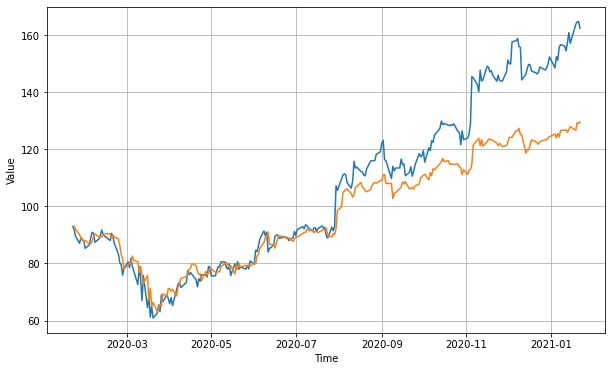

In [27]:
model = keras.models.load_model('my_checkpoint.h5')

rnn_forecast = model_forecast(model, data.values[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [28]:
print(keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

9.207631


In [35]:
keras.backend.clear_session()
tf.random.set_seed(6)
np.random.seed(6)

window_size = 60
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,
                           kernel_size=2,
                           strides=1,
                           dilation_rate=dilation_rate,
                           padding='causal',
                           activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
lambda epoch: 1e-4 * 10 ** (epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer, 
              metrics=['mae'])

history = model.fit(train_set, epochs=500, callbacks=[lr_schedule])

Epoch 1/500
8/8 [==============================] - 1s 31ms/step - loss: 59.8150 - mae: 60.3150
Epoch 2/500
8/8 [==============================] - 0s 25ms/step - loss: 59.0406 - mae: 59.5406
Epoch 3/500
8/8 [==============================] - 0s 25ms/step - loss: 57.3043 - mae: 57.8043
Epoch 4/500
8/8 [==============================] - 0s 27ms/step - loss: 55.4514 - mae: 55.9514
Epoch 5/500
8/8 [==============================] - 0s 26ms/step - loss: 53.7952 - mae: 54.2952
Epoch 6/500
8/8 [==============================] - 0s 25ms/step - loss: 50.6294 - mae: 51.1294
Epoch 7/500
8/8 [==============================] - 0s 26ms/step - loss: 47.0021 - mae: 47.5021
Epoch 8/500
8/8 [==============================] - 0s 25ms/step - loss: 42.2219 - mae: 42.7219
Epoch 9/500
8/8 [==============================] - 0s 26ms/step - loss: 34.3077 - mae: 34.8077
Epoch 10/500
8/8 [==============================] - 0s 26ms/step - loss: 23.8116 - mae: 24.3069
Epoch 11/500
8/8 [==============================]

8/8 [==============================] - 0s 25ms/step - loss: 7.3213 - mae: 7.8096
Epoch 88/500
8/8 [==============================] - 0s 25ms/step - loss: 6.6474 - mae: 7.1294
Epoch 89/500
8/8 [==============================] - 0s 27ms/step - loss: 28.0529 - mae: 28.5522
Epoch 90/500
8/8 [==============================] - 0s 27ms/step - loss: 19.0991 - mae: 19.5988
Epoch 91/500
8/8 [==============================] - 0s 25ms/step - loss: 27.0149 - mae: 27.5138
Epoch 92/500
8/8 [==============================] - 0s 25ms/step - loss: 25.5598 - mae: 26.0586
Epoch 93/500
8/8 [==============================] - 0s 25ms/step - loss: 23.3473 - mae: 23.8463
Epoch 94/500
8/8 [==============================] - 0s 25ms/step - loss: 11.1900 - mae: 11.6810
Epoch 95/500
8/8 [==============================] - 0s 27ms/step - loss: 9.8887 - mae: 10.3824
Epoch 96/500
8/8 [==============================] - 0s 26ms/step - loss: 5.7726 - mae: 6.2538
Epoch 97/500
8/8 [==============================] - 0s 25ms/

8/8 [==============================] - 0s 26ms/step - loss: 7.3360 - mae: 7.8239
Epoch 174/500
8/8 [==============================] - 0s 27ms/step - loss: 7.2610 - mae: 7.7559
Epoch 175/500
8/8 [==============================] - 0s 26ms/step - loss: 7.2997 - mae: 7.7904
Epoch 176/500
8/8 [==============================] - 0s 26ms/step - loss: 7.2606 - mae: 7.7507
Epoch 177/500
8/8 [==============================] - 0s 26ms/step - loss: 7.2379 - mae: 7.7292
Epoch 178/500
8/8 [==============================] - 0s 25ms/step - loss: 7.2714 - mae: 7.7659
Epoch 179/500
8/8 [==============================] - 0s 24ms/step - loss: 7.0207 - mae: 7.5082
Epoch 180/500
8/8 [==============================] - 0s 26ms/step - loss: 7.1265 - mae: 7.6148
Epoch 181/500
8/8 [==============================] - 0s 25ms/step - loss: 7.4454 - mae: 7.9318
Epoch 182/500
8/8 [==============================] - 0s 25ms/step - loss: 7.4800 - mae: 7.9690
Epoch 183/500
8/8 [==============================] - 0s 25ms/ste

8/8 [==============================] - 0s 26ms/step - loss: 4208.4623 - mae: 4208.9623
Epoch 257/500
8/8 [==============================] - 0s 26ms/step - loss: 4018.2090 - mae: 4018.7091
Epoch 258/500
8/8 [==============================] - 0s 24ms/step - loss: 4102.6978 - mae: 4103.1979
Epoch 259/500
8/8 [==============================] - 0s 25ms/step - loss: 5249.0986 - mae: 5249.5984
Epoch 260/500
8/8 [==============================] - 0s 25ms/step - loss: 5019.4437 - mae: 5019.9436
Epoch 261/500
8/8 [==============================] - 0s 25ms/step - loss: 5121.2390 - mae: 5121.7388
Epoch 262/500
8/8 [==============================] - 0s 25ms/step - loss: 6552.3472 - mae: 6552.8471
Epoch 263/500
8/8 [==============================] - 0s 26ms/step - loss: 6270.9951 - mae: 6271.4950
Epoch 264/500
8/8 [==============================] - 0s 24ms/step - loss: 6396.7630 - mae: 6397.2632
Epoch 265/500
8/8 [==============================] - 0s 26ms/step - loss: 8180.5274 - mae: 8181.0271
Epoc

8/8 [==============================] - 0s 26ms/step - loss: 1400215.3750 - mae: 1400216.0139
Epoch 336/500
8/8 [==============================] - 0s 25ms/step - loss: 1426017.4444 - mae: 1426017.8750
Epoch 337/500
8/8 [==============================] - 0s 26ms/step - loss: 1823108.1389 - mae: 1823108.3750
Epoch 338/500
8/8 [==============================] - 0s 26ms/step - loss: 1757411.4583 - mae: 1757411.8333
Epoch 339/500
8/8 [==============================] - 0s 27ms/step - loss: 1789799.7778 - mae: 1789800.1806
Epoch 340/500
8/8 [==============================] - 0s 28ms/step - loss: 2288234.0000 - mae: 2288234.5556
Epoch 341/500
8/8 [==============================] - 0s 27ms/step - loss: 2205942.9861 - mae: 2205943.5694
Epoch 342/500
8/8 [==============================] - 0s 30ms/step - loss: 2246623.9583 - mae: 2246624.4444
Epoch 343/500
8/8 [==============================] - 0s 26ms/step - loss: 2872309.2222 - mae: 2872309.7222
Epoch 344/500
8/8 [==============================] 

8/8 [==============================] - 0s 25ms/step - loss: 419760970.6667 - mae: 419760977.7778
Epoch 411/500
8/8 [==============================] - 0s 26ms/step - loss: 427559941.3333 - mae: 427559952.0000
Epoch 412/500
8/8 [==============================] - 0s 26ms/step - loss: 546768451.5556 - mae: 546768465.7778
Epoch 413/500
8/8 [==============================] - 0s 27ms/step - loss: 527702382.2222 - mae: 527702410.6667
Epoch 414/500
8/8 [==============================] - 0s 24ms/step - loss: 537507736.8889 - mae: 537507722.6667
Epoch 415/500
8/8 [==============================] - 0s 25ms/step - loss: 687375374.2222 - mae: 687375367.1111
Epoch 416/500
8/8 [==============================] - 0s 25ms/step - loss: 663428494.2222 - mae: 663428522.6667
Epoch 417/500
8/8 [==============================] - 0s 25ms/step - loss: 675756999.1111 - mae: 675756992.0000
Epoch 418/500
8/8 [==============================] - 0s 25ms/step - loss: 864179335.1111 - mae: 864179328.0000
Epoch 419/500
8

8/8 [==============================] - 0s 25ms/step - loss: 102832024234.6667 - mae: 102832027875.5556
Epoch 483/500
8/8 [==============================] - 0s 25ms/step - loss: 104749942101.3333 - mae: 104749945742.2222
Epoch 484/500
8/8 [==============================] - 0s 26ms/step - loss: 133971519260.4444 - mae: 133971512888.8889
Epoch 485/500
8/8 [==============================] - 0s 26ms/step - loss: 129363075982.2222 - mae: 129363067790.2222
Epoch 486/500
8/8 [==============================] - 0s 27ms/step - loss: 131775939470.2222 - mae: 131775940380.4444
Epoch 487/500
8/8 [==============================] - 0s 25ms/step - loss: 168537746090.6667 - mae: 168537751552.0000
Epoch 488/500
8/8 [==============================] - 0s 26ms/step - loss: 162742889130.6667 - mae: 162742885489.7778
Epoch 489/500
8/8 [==============================] - 0s 25ms/step - loss: 165778781525.3333 - mae: 165778783345.7778
Epoch 490/500
8/8 [==============================] - 0s 29ms/step - loss: 2120

(0.0001, 0.1, 0.0, 30.0)

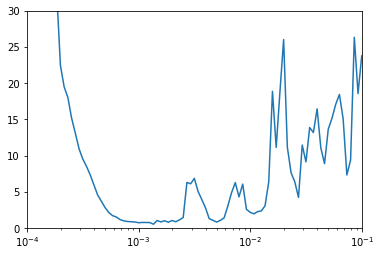

In [36]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1e-1, 0, 30])

In [40]:
keras.backend.clear_session()
tf.random.set_seed(6)
np.random.seed(6)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
    keras.layers.Conv1D(filters=32,
                       kernel_size=2,
                       strides=1,
                       padding='causal',
                       activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer=keras.optimizers.Adam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint(
'my_checkpoint.h5', save_best_only = True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500, validation_data=valid_set,
                   callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 1s 46ms/step - loss: 57.0638 - mae: 57.5638 - val_loss: 73.2442 - val_mae: 73.7442
Epoch 2/500
8/8 [==============================] - 0s 24ms/step - loss: 35.6078 - mae: 36.1074 - val_loss: 15.8763 - val_mae: 16.3737
Epoch 3/500
8/8 [==============================] - 0s 25ms/step - loss: 13.7486 - mae: 14.2474 - val_loss: 11.4659 - val_mae: 11.9572
Epoch 4/500
8/8 [==============================] - 0s 24ms/step - loss: 8.2501 - mae: 8.7444 - val_loss: 11.3713 - val_mae: 11.8643
Epoch 5/500
8/8 [==============================] - 0s 24ms/step - loss: 6.3117 - mae: 6.7995 - val_loss: 7.6580 - val_mae: 8.1403
Epoch 6/500
8/8 [==============================] - 0s 23ms/step - loss: 3.9986 - mae: 4.4611 - val_loss: 7.0941 - val_mae: 7.5737
Epoch 7/500
8/8 [==============================] - 0s 24ms/step - loss: 3.3926 - mae: 3.8320 - val_loss: 5.8622 - val_mae: 6.3317
Epoch 8/500
8/8 [==============================] - 0s 25ms/step - loss: 2.79

8/8 [==============================] - 0s 25ms/step - loss: 0.4668 - mae: 0.8015 - val_loss: 1.8316 - val_mae: 2.2766
Epoch 64/500
8/8 [==============================] - 0s 26ms/step - loss: 0.4453 - mae: 0.7778 - val_loss: 1.7767 - val_mae: 2.2157
Epoch 65/500
8/8 [==============================] - 0s 24ms/step - loss: 0.4848 - mae: 0.8334 - val_loss: 1.7540 - val_mae: 2.1957
Epoch 66/500
8/8 [==============================] - 0s 26ms/step - loss: 0.4629 - mae: 0.8046 - val_loss: 1.7932 - val_mae: 2.2318
Epoch 67/500
8/8 [==============================] - 0s 30ms/step - loss: 0.4673 - mae: 0.8084 - val_loss: 1.9189 - val_mae: 2.3691
Epoch 68/500
8/8 [==============================] - 0s 24ms/step - loss: 0.4709 - mae: 0.8145 - val_loss: 2.0027 - val_mae: 2.4536
Epoch 69/500
8/8 [==============================] - 0s 26ms/step - loss: 0.4926 - mae: 0.8420 - val_loss: 1.8490 - val_mae: 2.3060
Epoch 70/500
8/8 [==============================] - 0s 25ms/step - loss: 0.5933 - mae: 0.9795 - 

In [41]:
model = keras.models.load_model("my_checkpoint.h5")

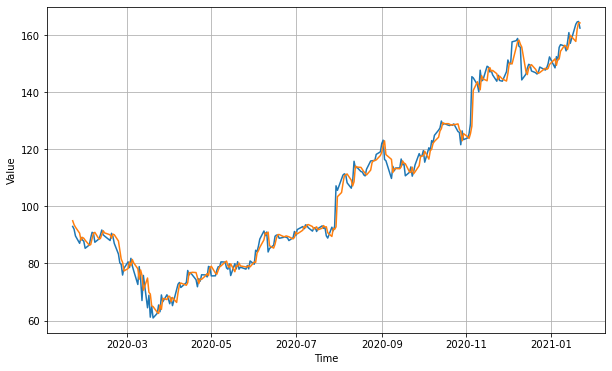

In [42]:
cnn_forecast = model_forecast(model, data.values[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)


In [43]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

2.1092958

In [50]:
cnn_forecast = model_forecast(model, data.values[..., np.newaxis], window_size)

cnn_forecast[split_time - window_size:-1, -1, 0]

array([ 94.9563  ,  93.572556,  92.714096,  90.58777 ,  88.11644 ,
        89.142586,  88.82345 ,  88.144875,  86.393684,  86.59979 ,
        88.72218 ,  90.58479 ,  90.88589 ,  88.50981 ,  88.75078 ,
        90.05255 ,  91.46033 ,  90.71369 ,  90.03174 ,  88.852684,
        90.270454,  90.06703 ,  87.87966 ,  84.77587 ,  81.542465,
        80.38967 ,  77.37716 ,  78.22438 ,  80.5035  ,  79.2247  ,
        81.39746 ,  80.22656 ,  78.1485  ,  74.478714,  77.71423 ,
        75.852875,  70.64645 ,  74.897766,  69.91461 ,  69.287796,
        65.131645,  64.89065 ,  62.896694,  62.492363,  65.42849 ,
        63.897324,  67.77307 ,  67.352806,  68.504135,  68.48886 ,
        66.616486,  68.087585,  66.35064 ,  69.76733 ,  72.4858  ,
        73.1497  ,  72.3727  ,  73.28492 ,  76.85663 ,  76.48167 ,
        76.91098 ,  76.8222  ,  75.0822  ,  72.96583 ,  74.518486,
        74.43158 ,  75.761185,  76.4422  ,  75.73176 ,  78.49495 ,
        79.03229 ,  76.61461 ,  76.235695,  77.63006 ,  78.823